In [1]:
import clip 
import torch 
import pickle
import argparse
import numpy as np
from models import RewardMLP
import matplotlib.pyplot as plt
from natsort import natsorted
from glob import glob
from PIL import Image
from os.path import join
%matplotlib inline
DATA_PATH='/home/mandi/ARM/irl/CLIP_ARM'

ModuleNotFoundError: No module named 'models'

In [2]:
device = 'cuda:0'
model_name = "ViT-L/14" 
clip_model, preprocess = clip.load(model_name, device=device)
print('loaded CLIP model')
prompts = ["robot gripper tip touch square button"]
text = clip.tokenize(prompts).to(device)
print('Using prompt', prompts)
mlp = RewardMLP(clip_model=clip_model).to(device)


loaded CLIP model
Using prompt ['robot gripper tip touch square button']


In [51]:
model_path = '/home/mandi/ARM/irl/clip-tuned/'
model_name = 'Button-Latest-ConcatBatch-2x100Batch-256x512MLP'
step = 100 

model_name = 'Iteration0-3x50Batch'
step = 0
mlp.load_state_dict(torch.load(f'{model_path}/{model_name}/{step}.pt'))
print('Loaded model from {}, step {}'.format(model_name, step))

Loaded model from Iteration0-3x50Batch, step 0


In [5]:
task = 'push_button'
traj_path = 'iteration0/fail/'
paths = glob(join(DATA_PATH, task, traj_path, f'episode*'))

In [12]:
long_paths = [p for p in paths if len(glob(join(p, '*'))) >= 3 ]

In [56]:
vis_paths = long_paths[:10]
def get_imgs(traj_path, task='push_button', n_paths=10):
    paths = glob(join(DATA_PATH, task, traj_path, f'episode*'))
    long_paths = [p for p in paths if len(glob(join(p, '*'))) >= 3 ]
    vis_paths = long_paths[:n_paths]
    all_imgs = []
    for path in vis_paths:
        steps = natsorted(glob(f'{path}/*.pkl'))
        imgs = []
        for i, step in enumerate(steps):
            with open(step, 'rb') as f:
                transition = pickle.load(f)
            obs = transition.observation['front_rgb']
            if obs.shape[-1] != 3 and obs.shape[0] == 3:
                obs = obs.transpose(1,2,0)
            obs = Image.fromarray(np.uint8(obs))
            imgs.append(obs)

            if i == len(steps) - 1:
                final_obs = transition.final_observation['front_rgb']
                if final_obs.shape[-1] != 3 and final_obs.shape[0] == 3:
                    final_obs = final_obs.transpose(1,2,0)
                    obs = Image.fromarray(np.uint8(final_obs))
                    imgs.append(obs)
        all_imgs.append(imgs)
    return all_imgs

In [67]:
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize, RandomResizedCrop
try:
    from torchvision.transforms import InterpolationMode 
    BICUBIC = InterpolationMode.BICUBIC
except ImportError:
    BICUBIC = Image.BICUBIC
from torchvision.transforms import RandomHorizontalFlip, RandomVerticalFlip

def _convert_image_to_rgb(image):
    return image.convert("RGB")
aug_process = Compose([
            Resize(240, interpolation=BICUBIC),
            RandomResizedCrop(224, scale=(0.7, 1.0)),
            RandomHorizontalFlip(0.5),
            _convert_image_to_rgb,
            ToTensor(),
            Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
        ])
    
def compute_logits(all_imgs, mlp, aug_avg=False, aug_num=3):
    all_logits = []
    for imgs in all_imgs:
        if aug_avg:
            logits = 0
            for _ in range(aug_num):
                img_batch = torch.stack([aug_process(img) for img in imgs]).to(device)
                logits += mlp(img_batch, text, scale_logits=False).detach().cpu().numpy()
            logits /= aug_num
        else:
            img_batch = torch.stack([preprocess(img) for img in imgs]).to(device)
            logits = mlp(img_batch, text, scale_logits=False).detach().cpu().numpy()
        all_logits.append(logits)
    return all_logits

def show_logits(all_logits, all_imgs):
    ymax = max([max(logits) for logits in all_logits])
    ymin = min([min(logits) for logits in all_logits])
    
    max_traj_len = max([len(imgs) for imgs in all_imgs])
    fig, axs = plt.subplots(len(all_imgs), max_traj_len + 1, squeeze=False, figsize=(max_traj_len*4+4, 4*len(all_imgs)))
    for i, imgs in enumerate(all_imgs):
        for j, img in enumerate(imgs):
            r = i
            axs[r,j].imshow(imgs[j])
            axs[r,j].axis('off')
        #print(list(range(j)), all_logits[i].flatten().shape)
        axs[r,j+1].bar(x=list(range(j+1)), height=all_logits[i].flatten())
        axs[r,j+1].set_ylim(ymin, ymax) 
    plt.tight_layout()

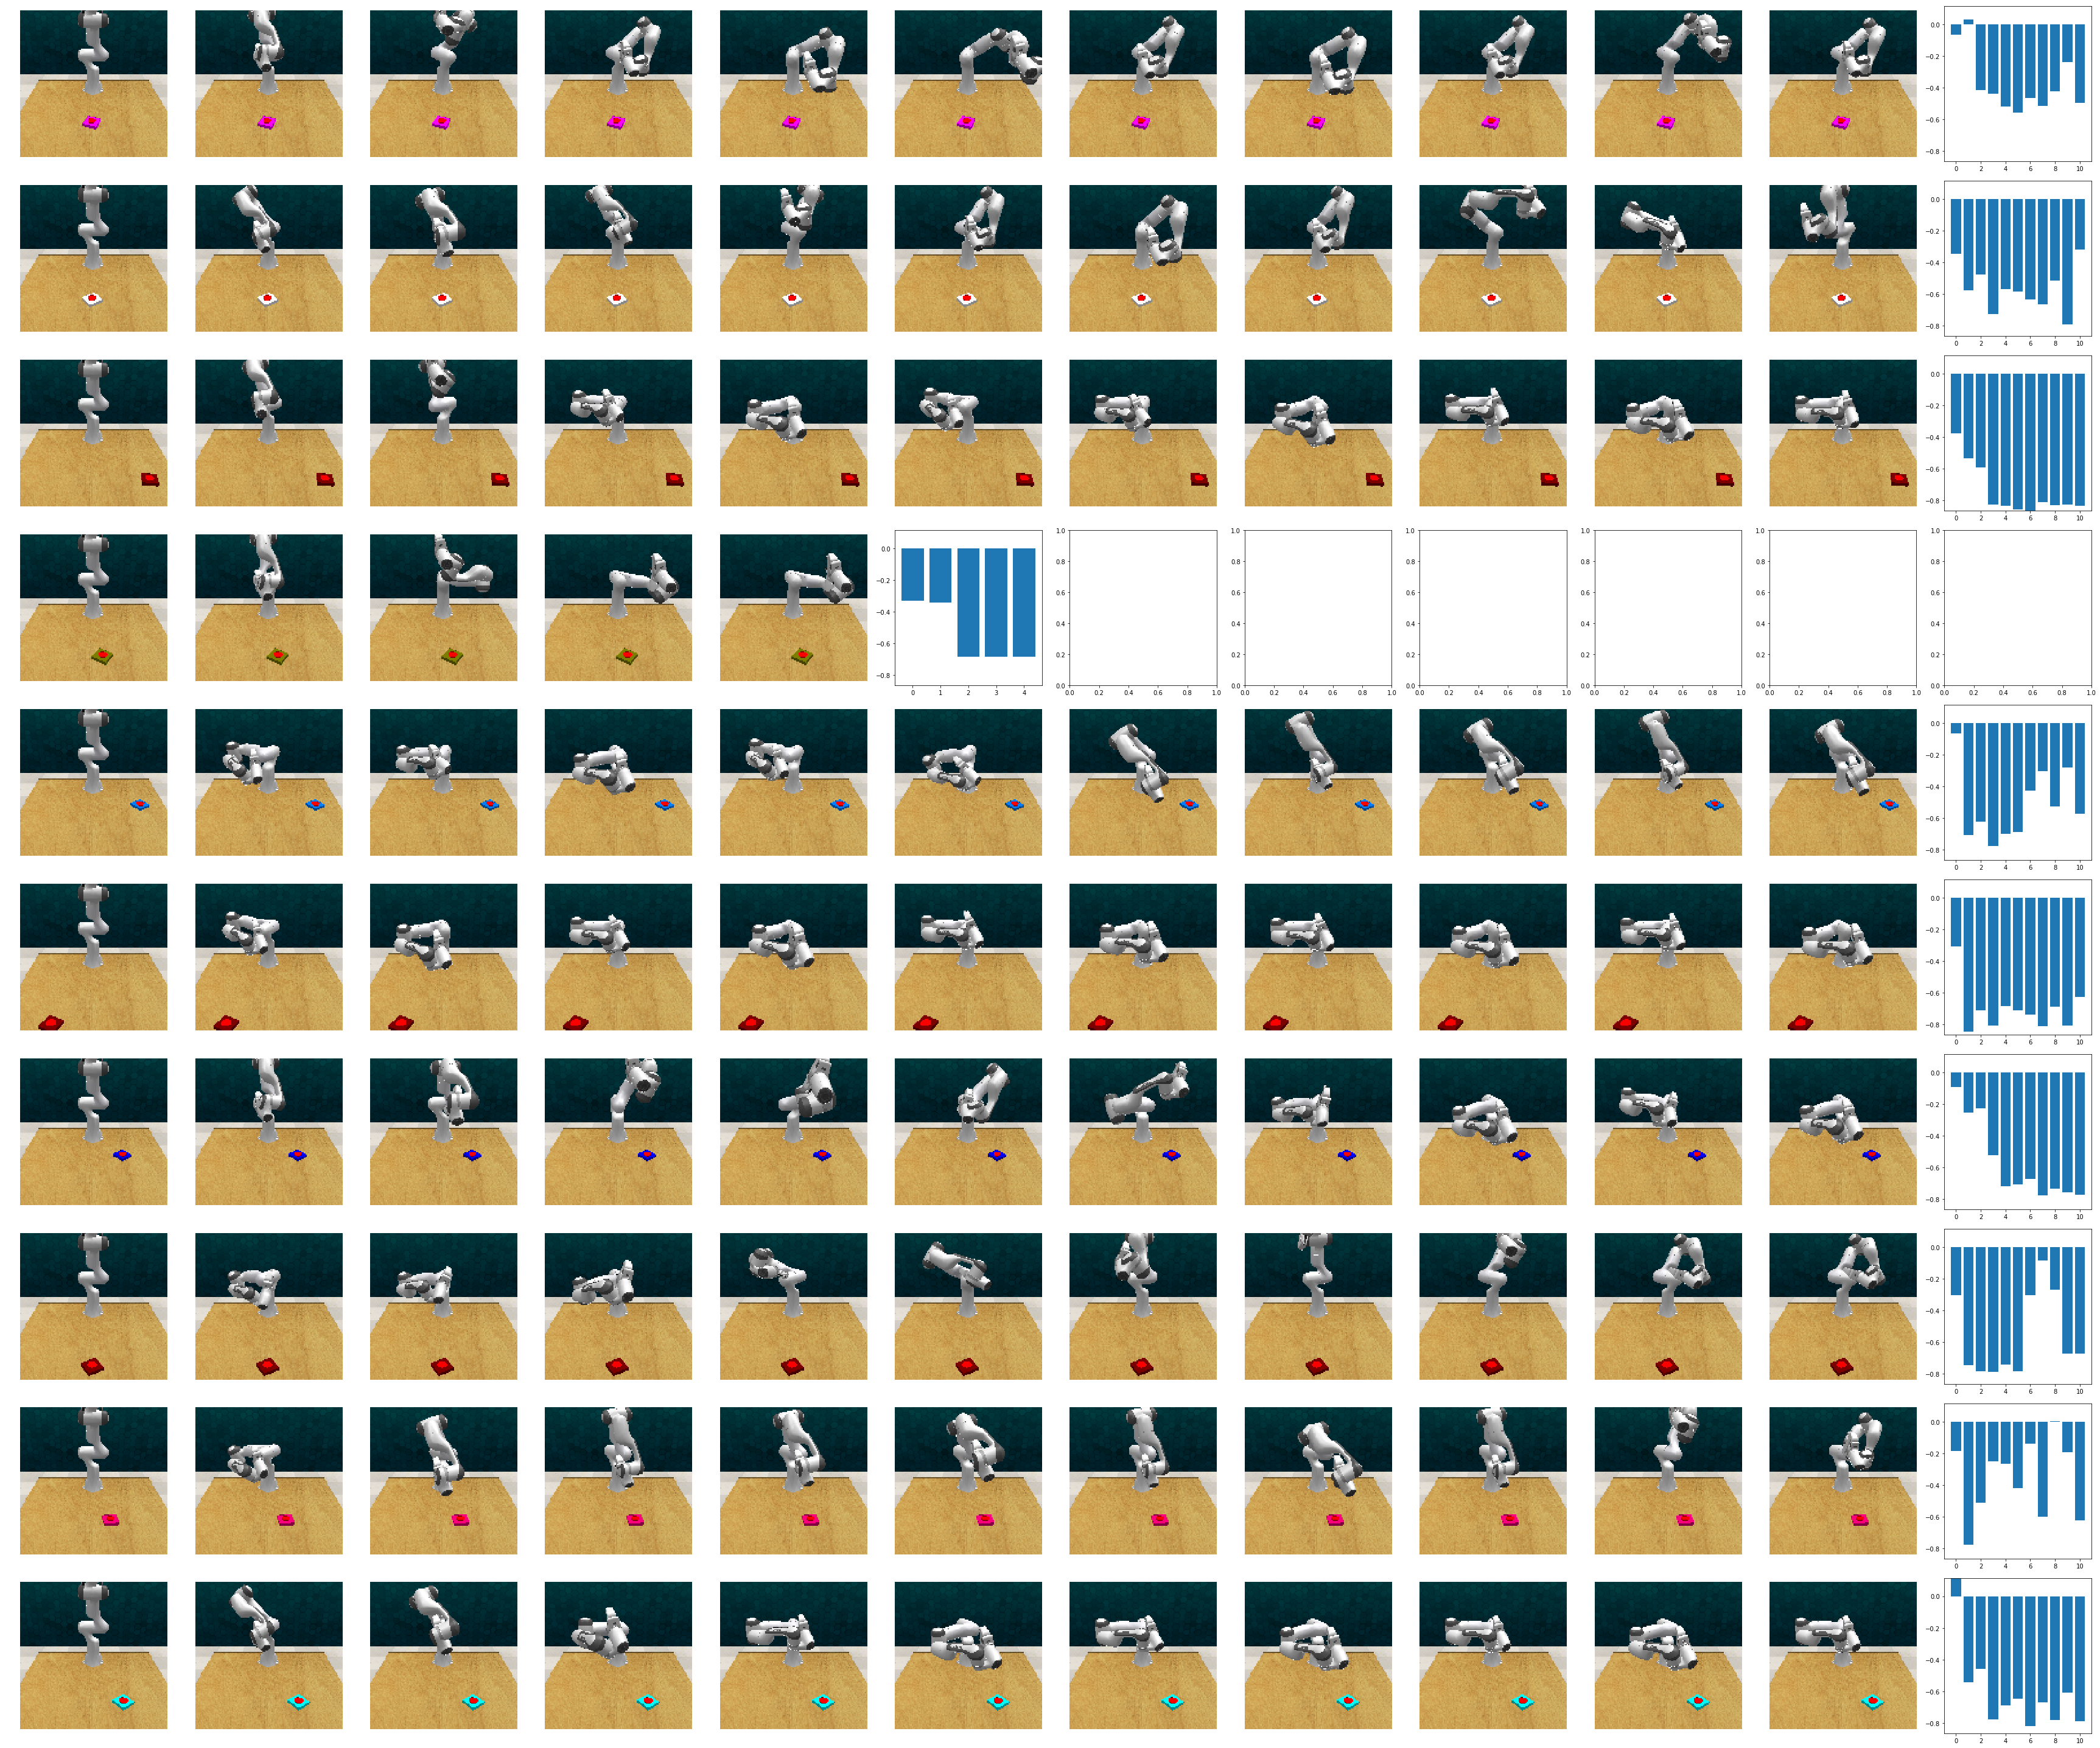

In [71]:
tuned_fail_logits = compute_logits(all_imgs, tuned) 
show_logits(tuned_fail_logits, all_imgs)

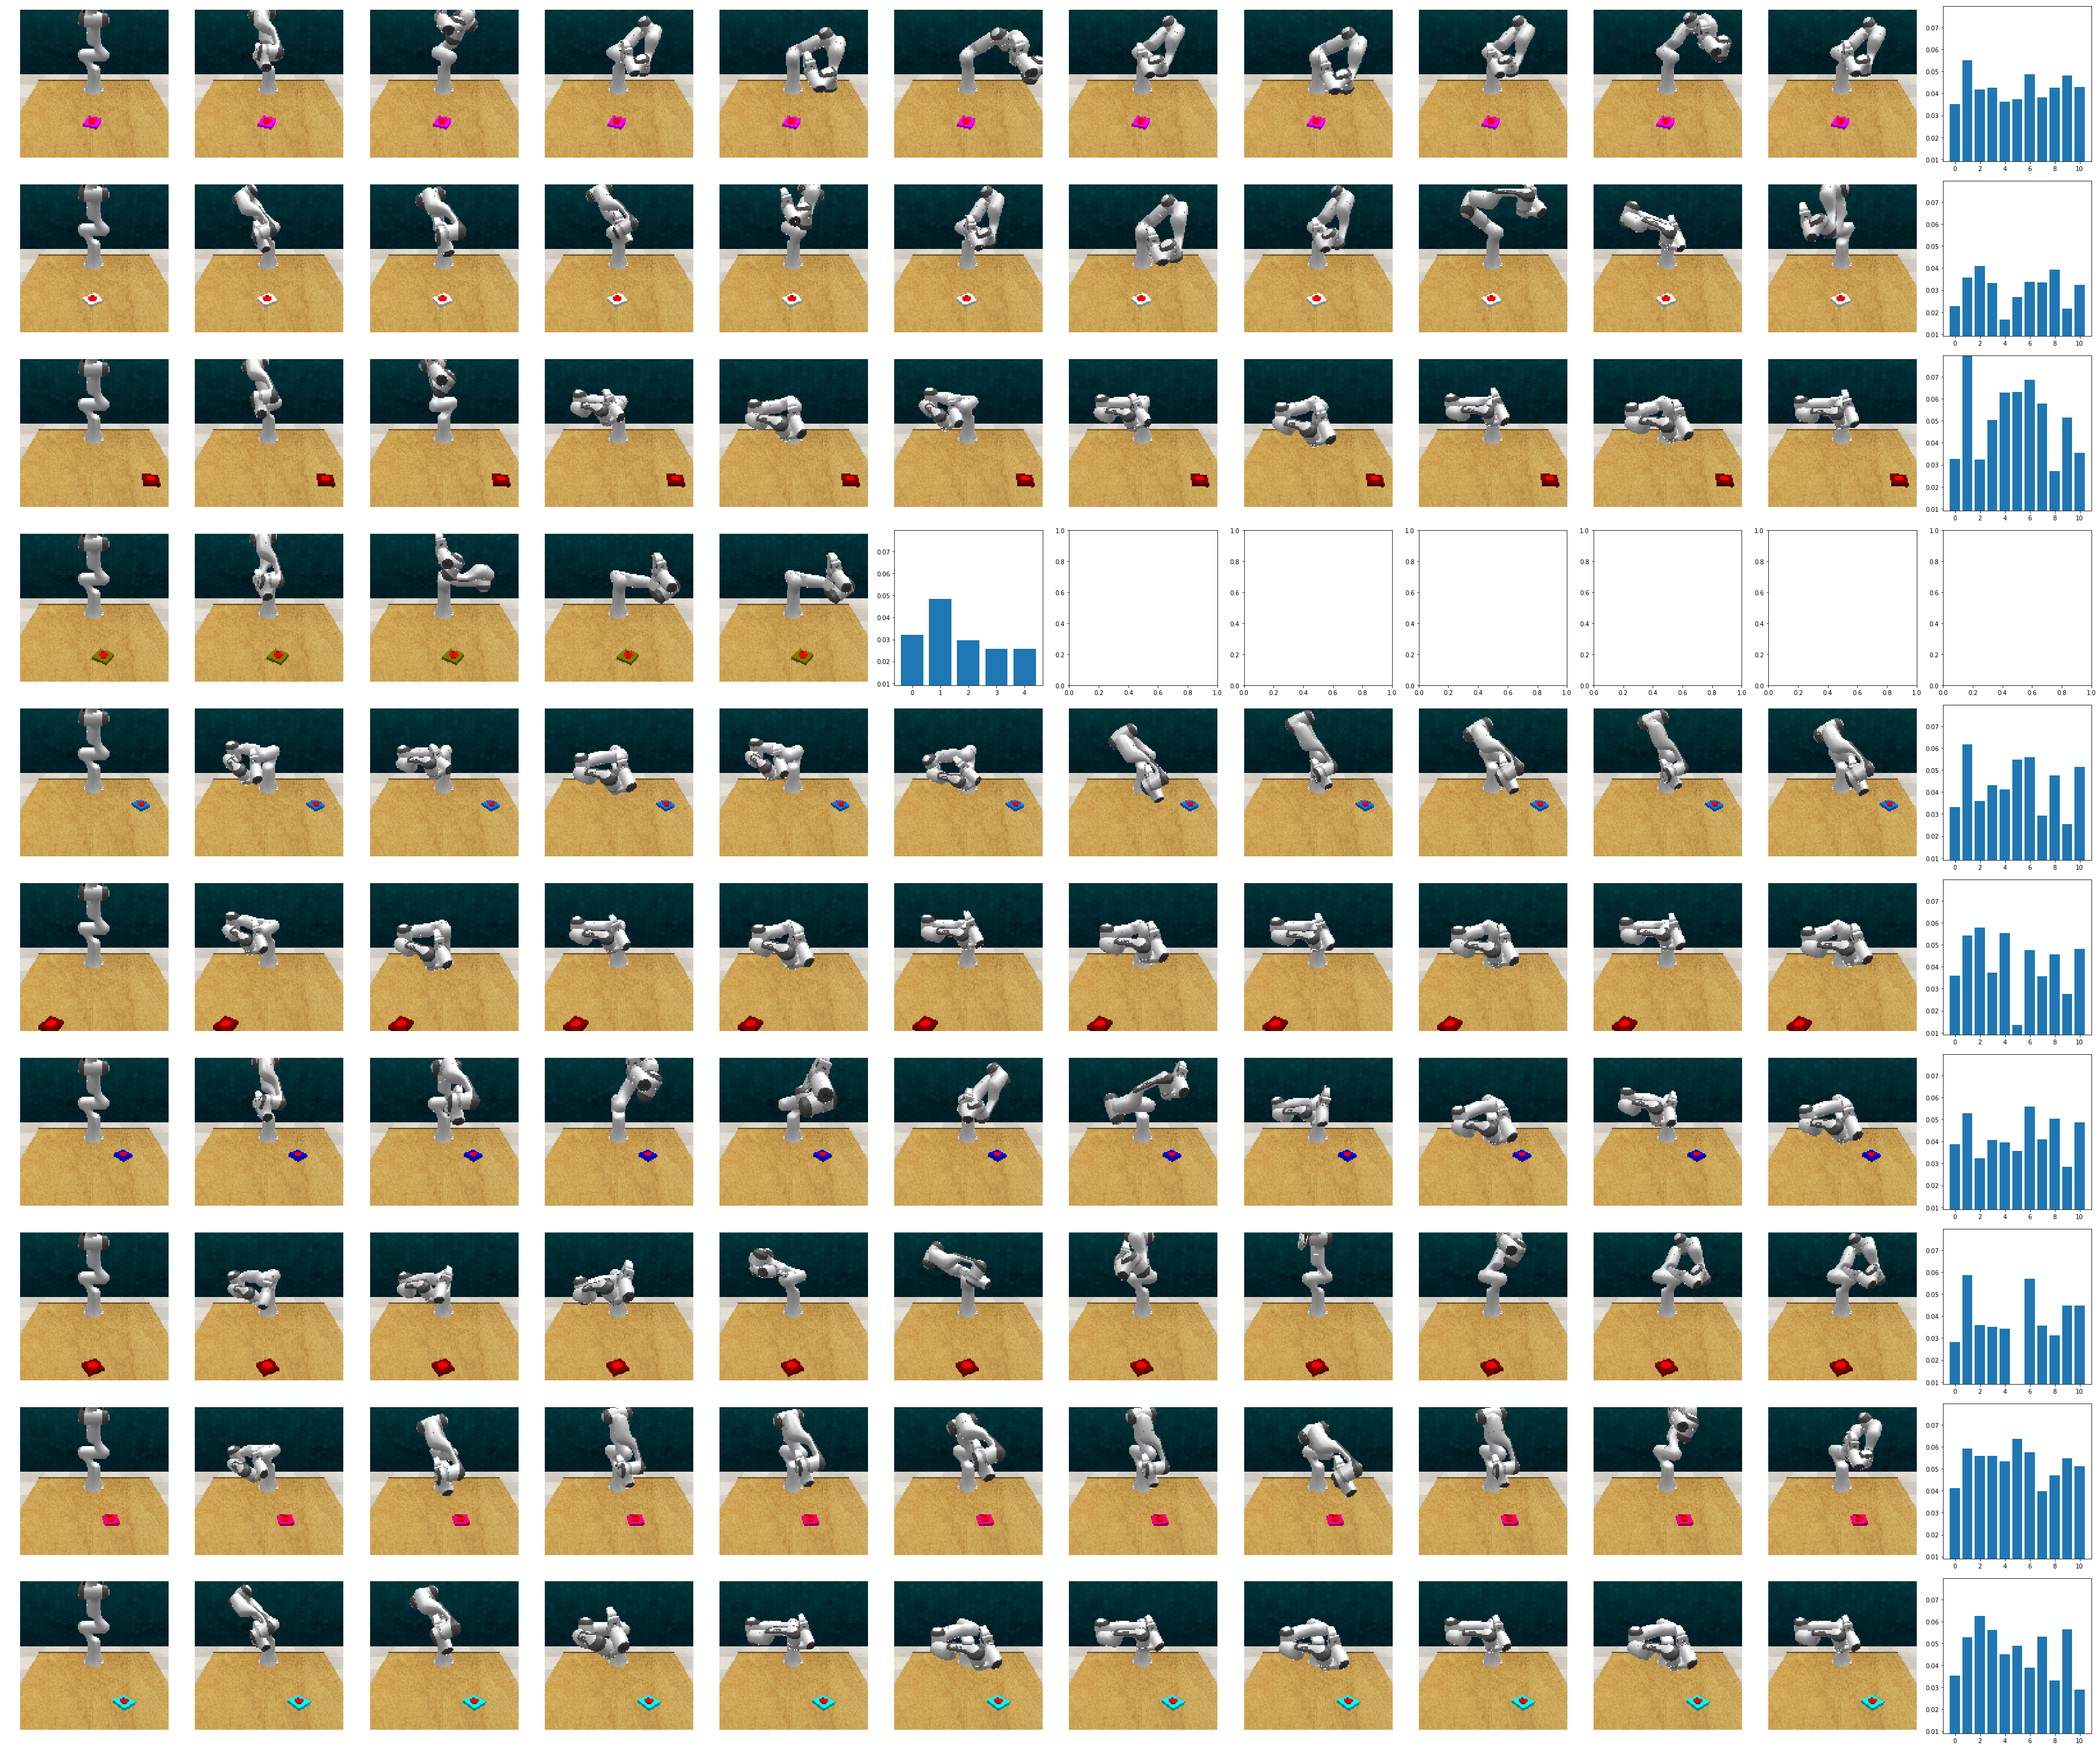

In [52]:
init_logits = compute_logits(all_imgs, mlp)
show_logits(init_logits, all_imgs)

In [57]:
succ_imgs = get_imgs('iteration0/success')

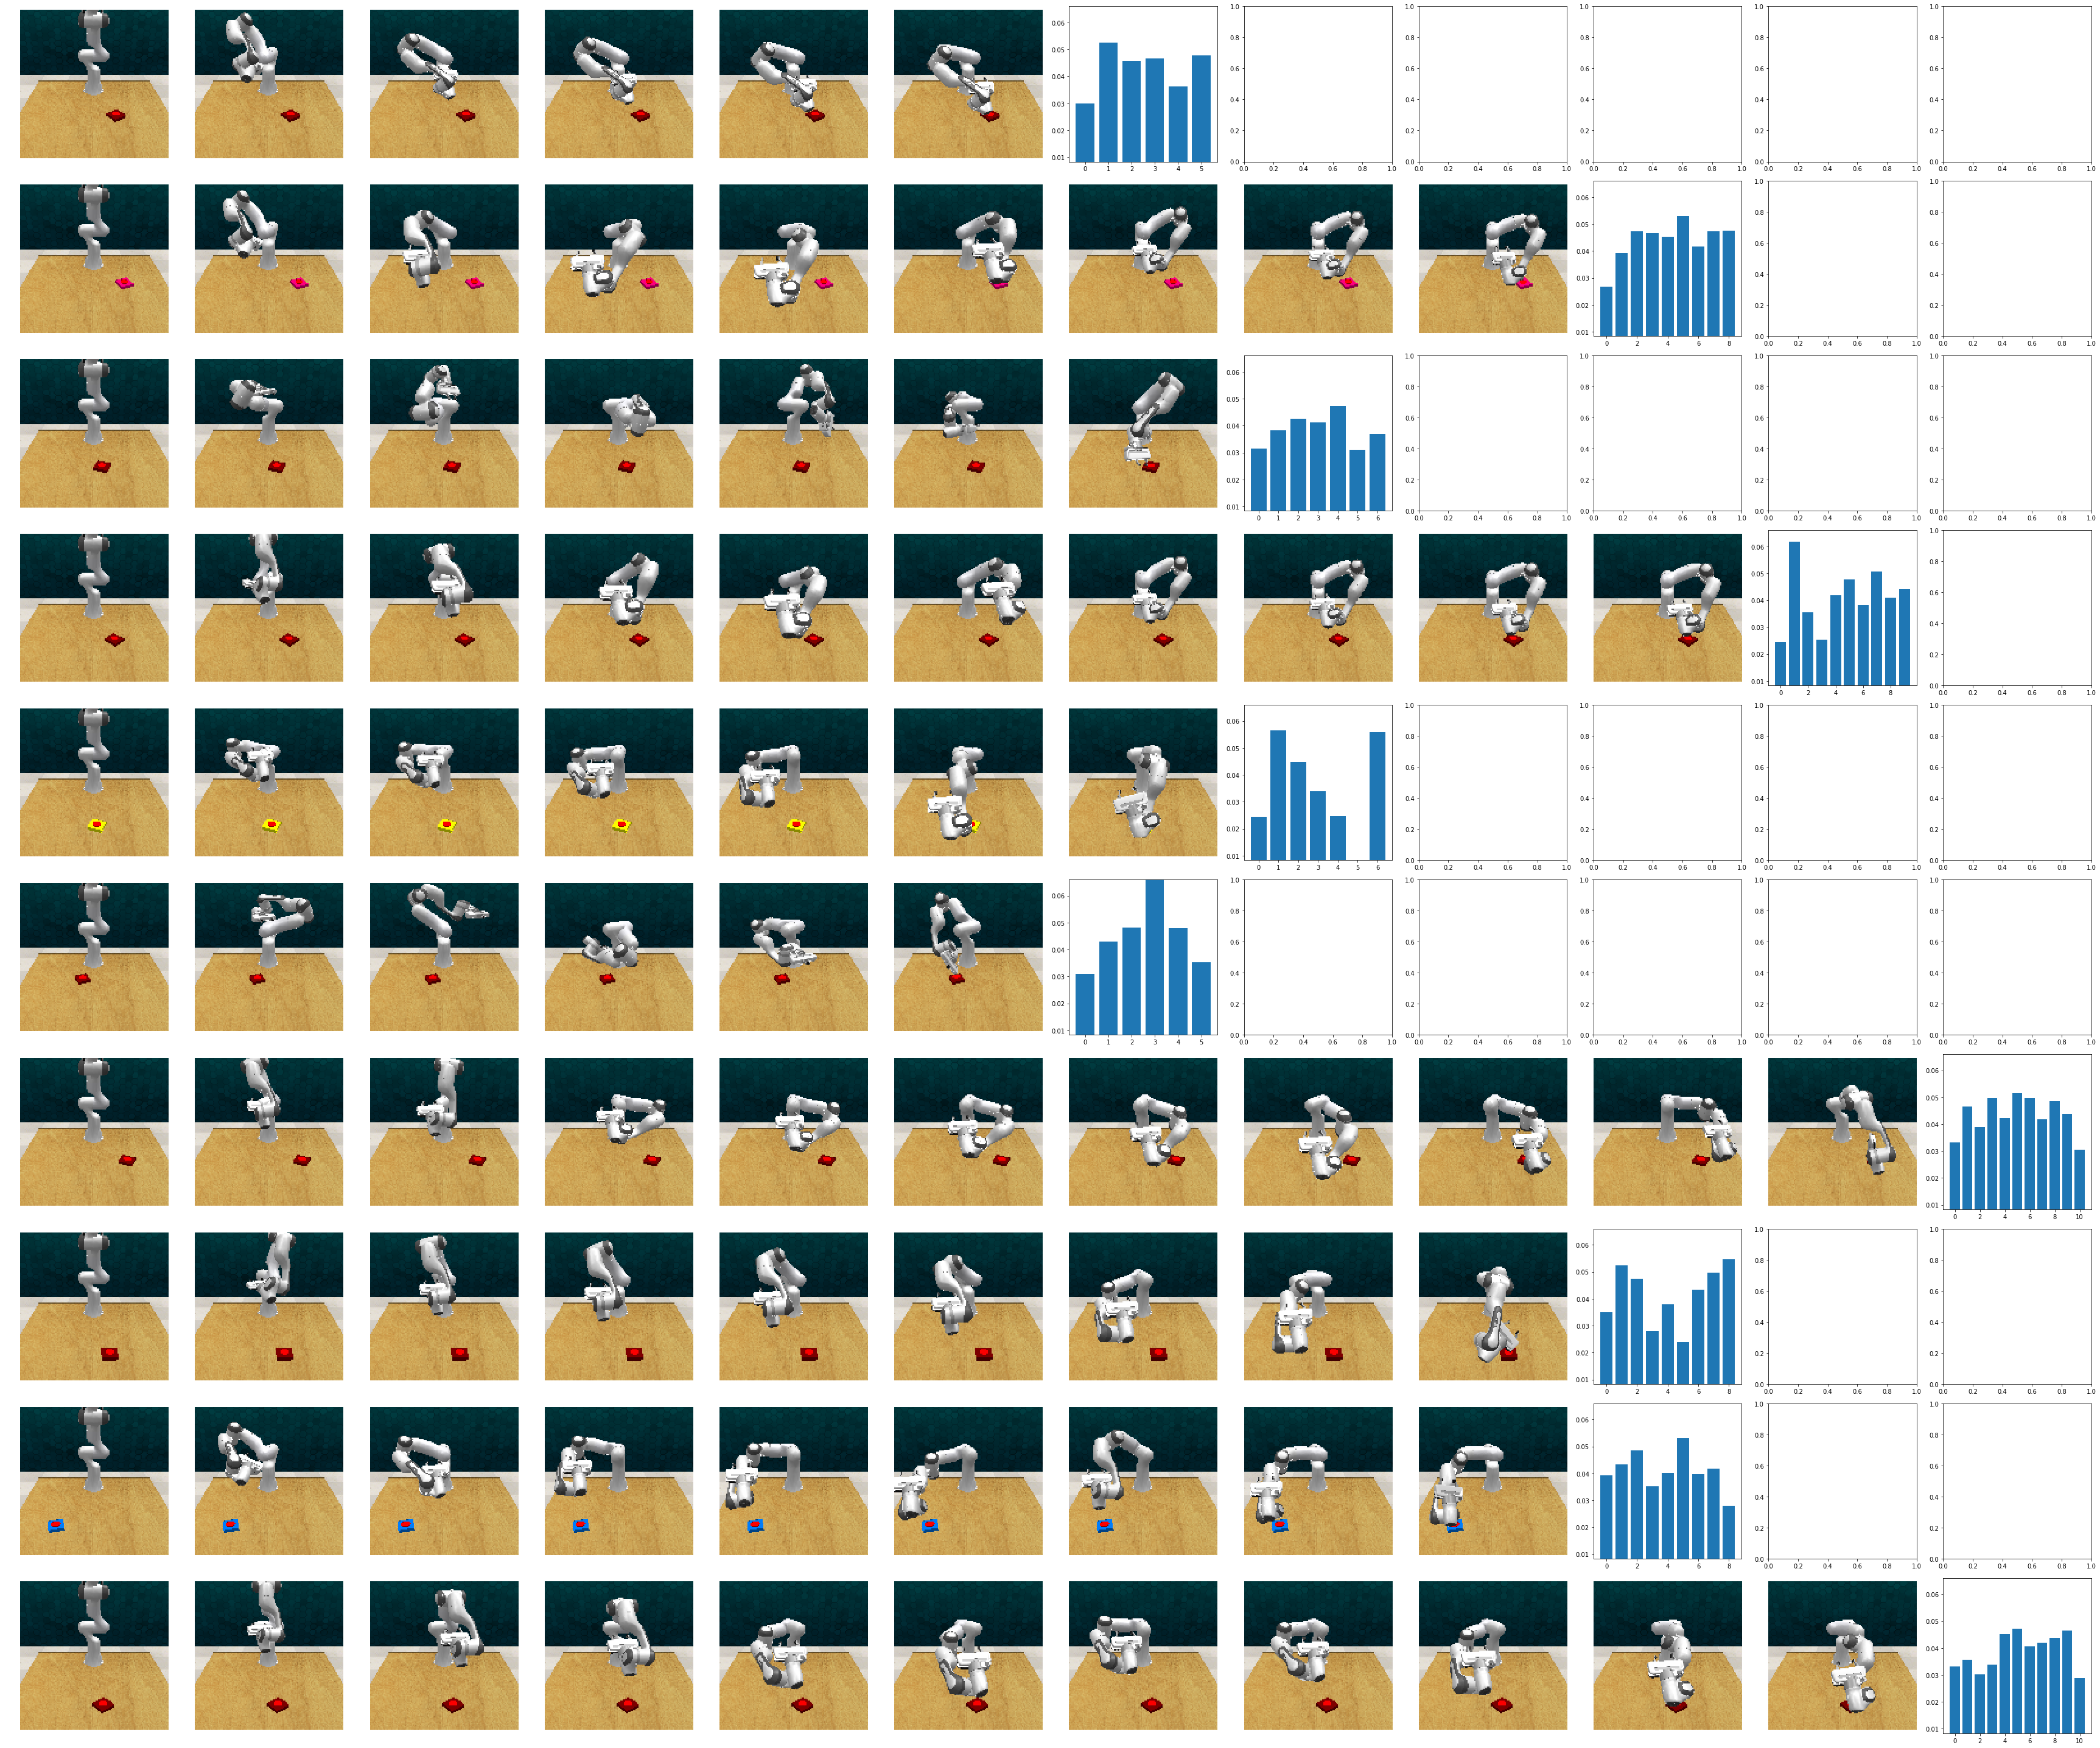

In [58]:
succ_logits = compute_logits(succ_imgs, mlp)
show_logits(succ_logits, succ_imgs)

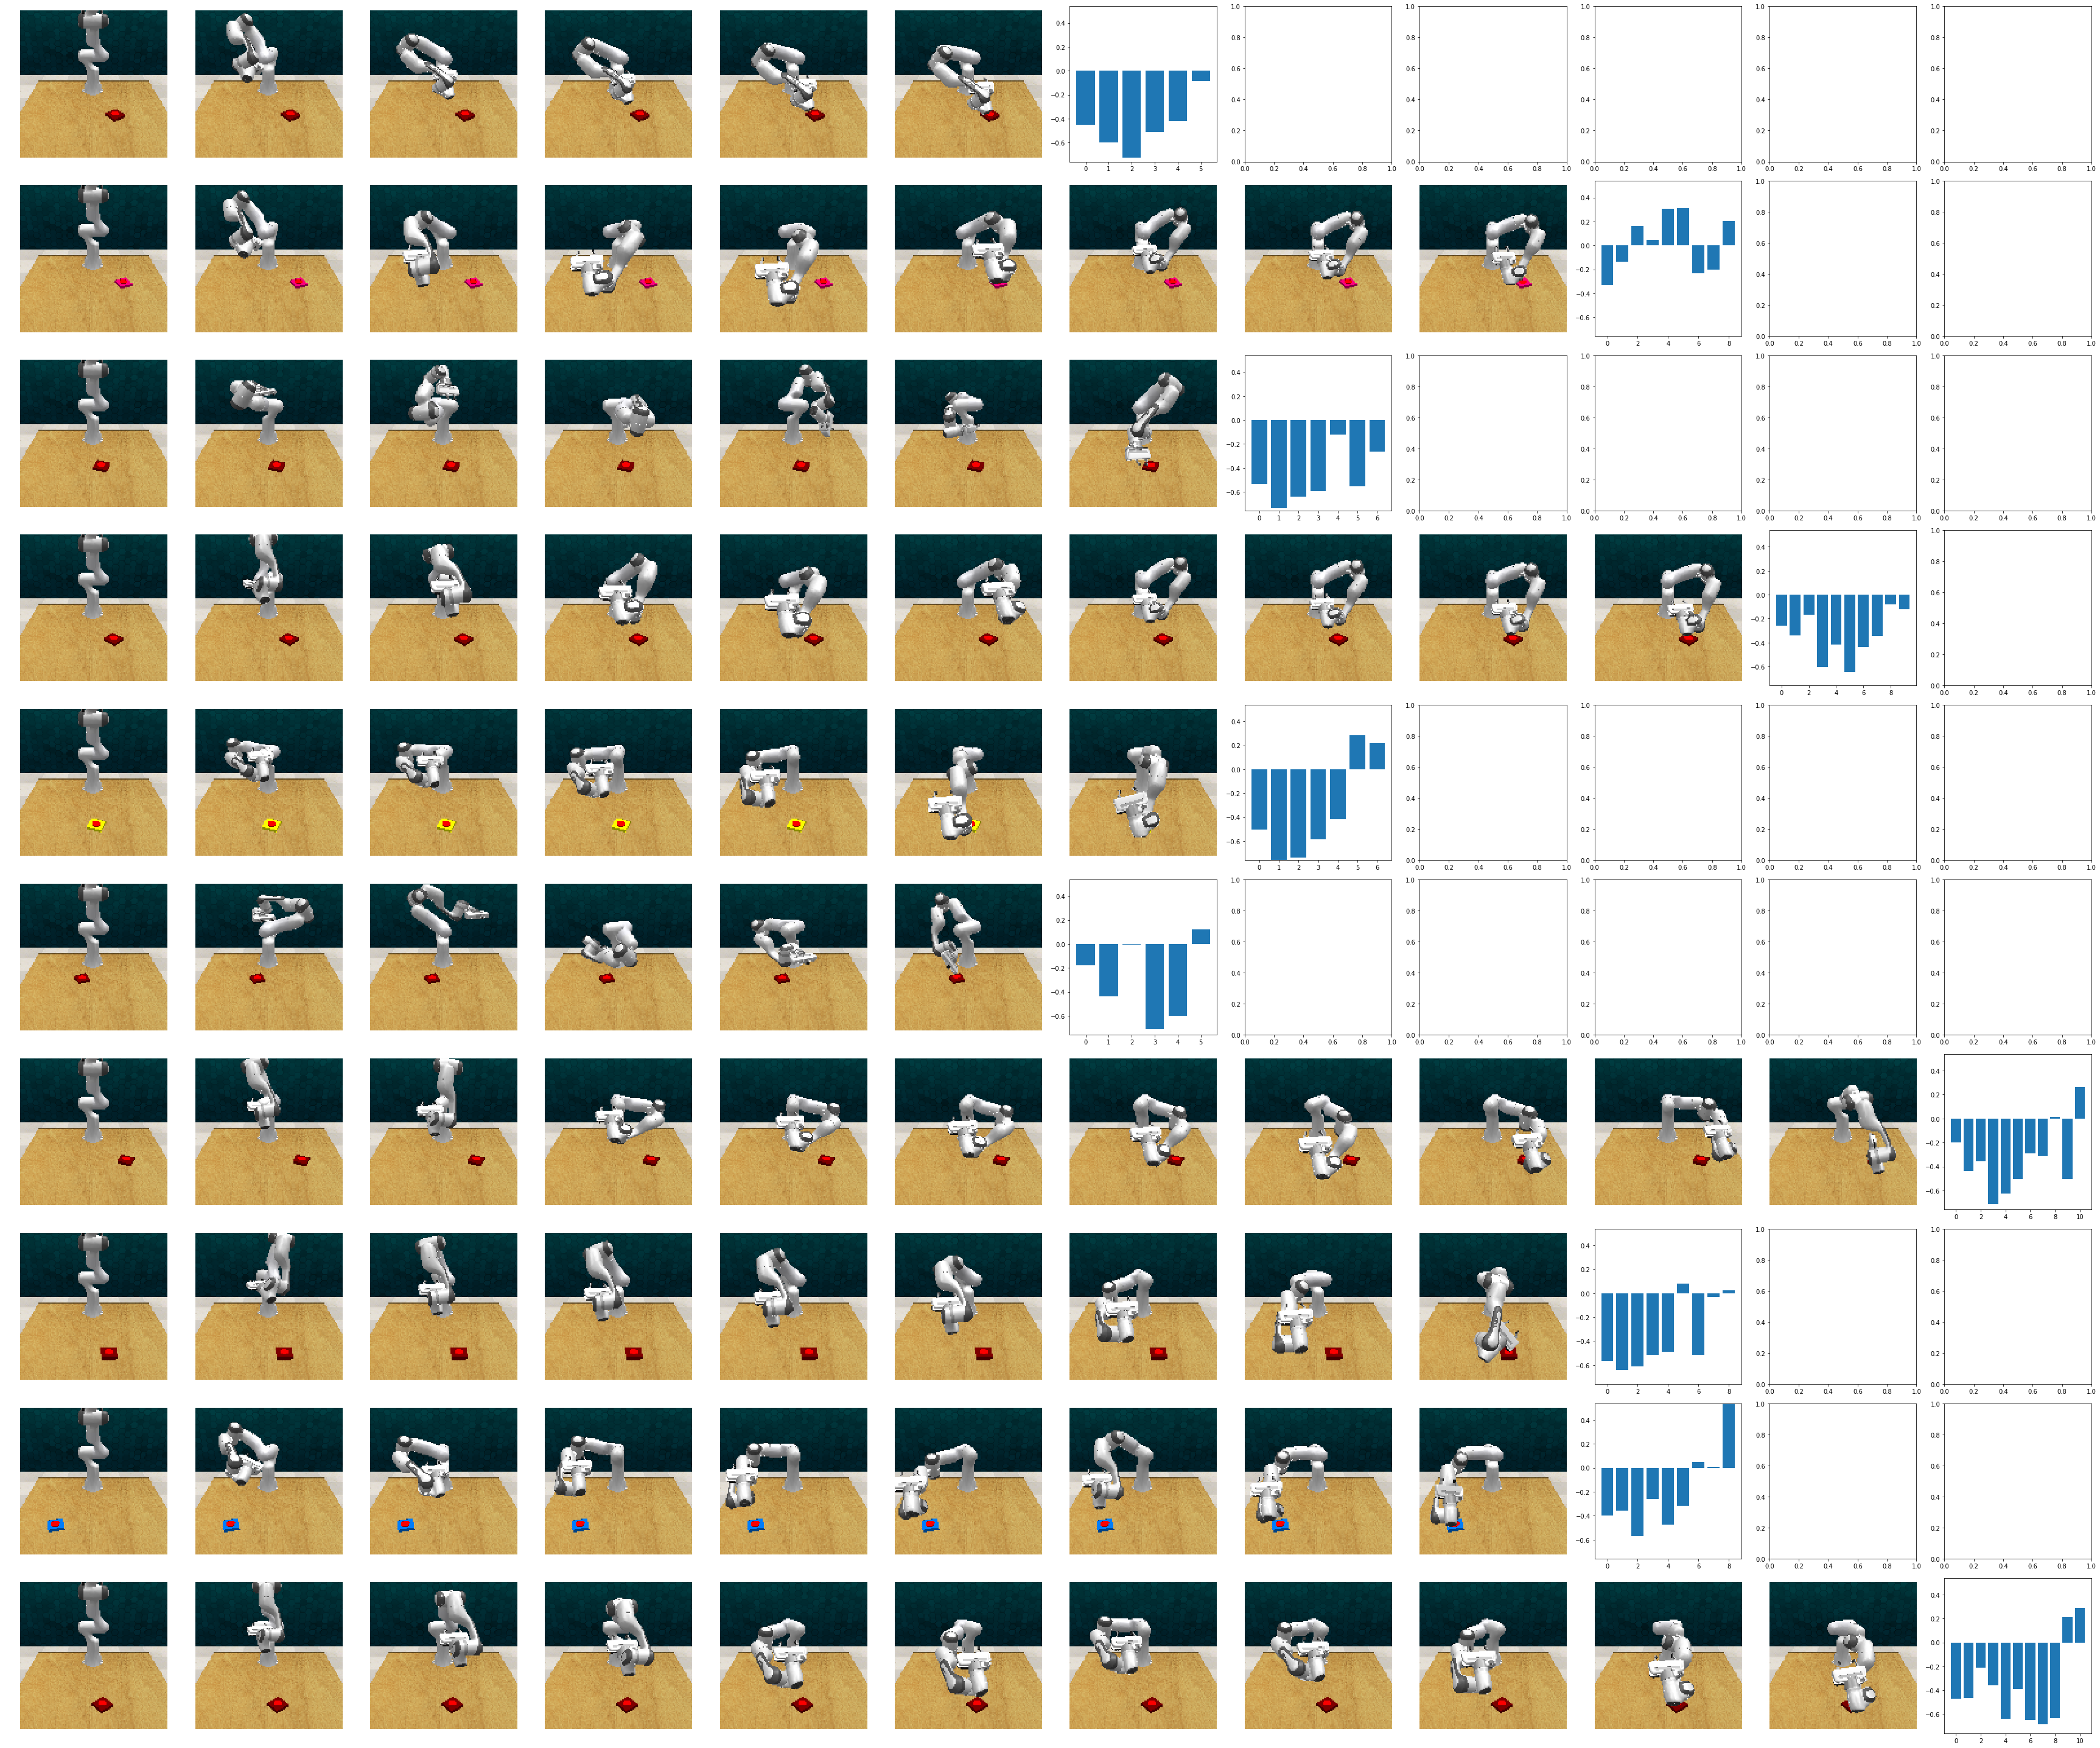

In [70]:
model_name = 'Iteration0-3x50Batch'
step = 450
tuned = RewardMLP(clip_model=clip_model).to(device)
tuned.load_state_dict(torch.load(f'{model_path}/{model_name}/{step}.pt'))
tuned_logits = compute_logits(succ_imgs, tuned, aug_avg=True)
show_logits(tuned_logits, succ_imgs)

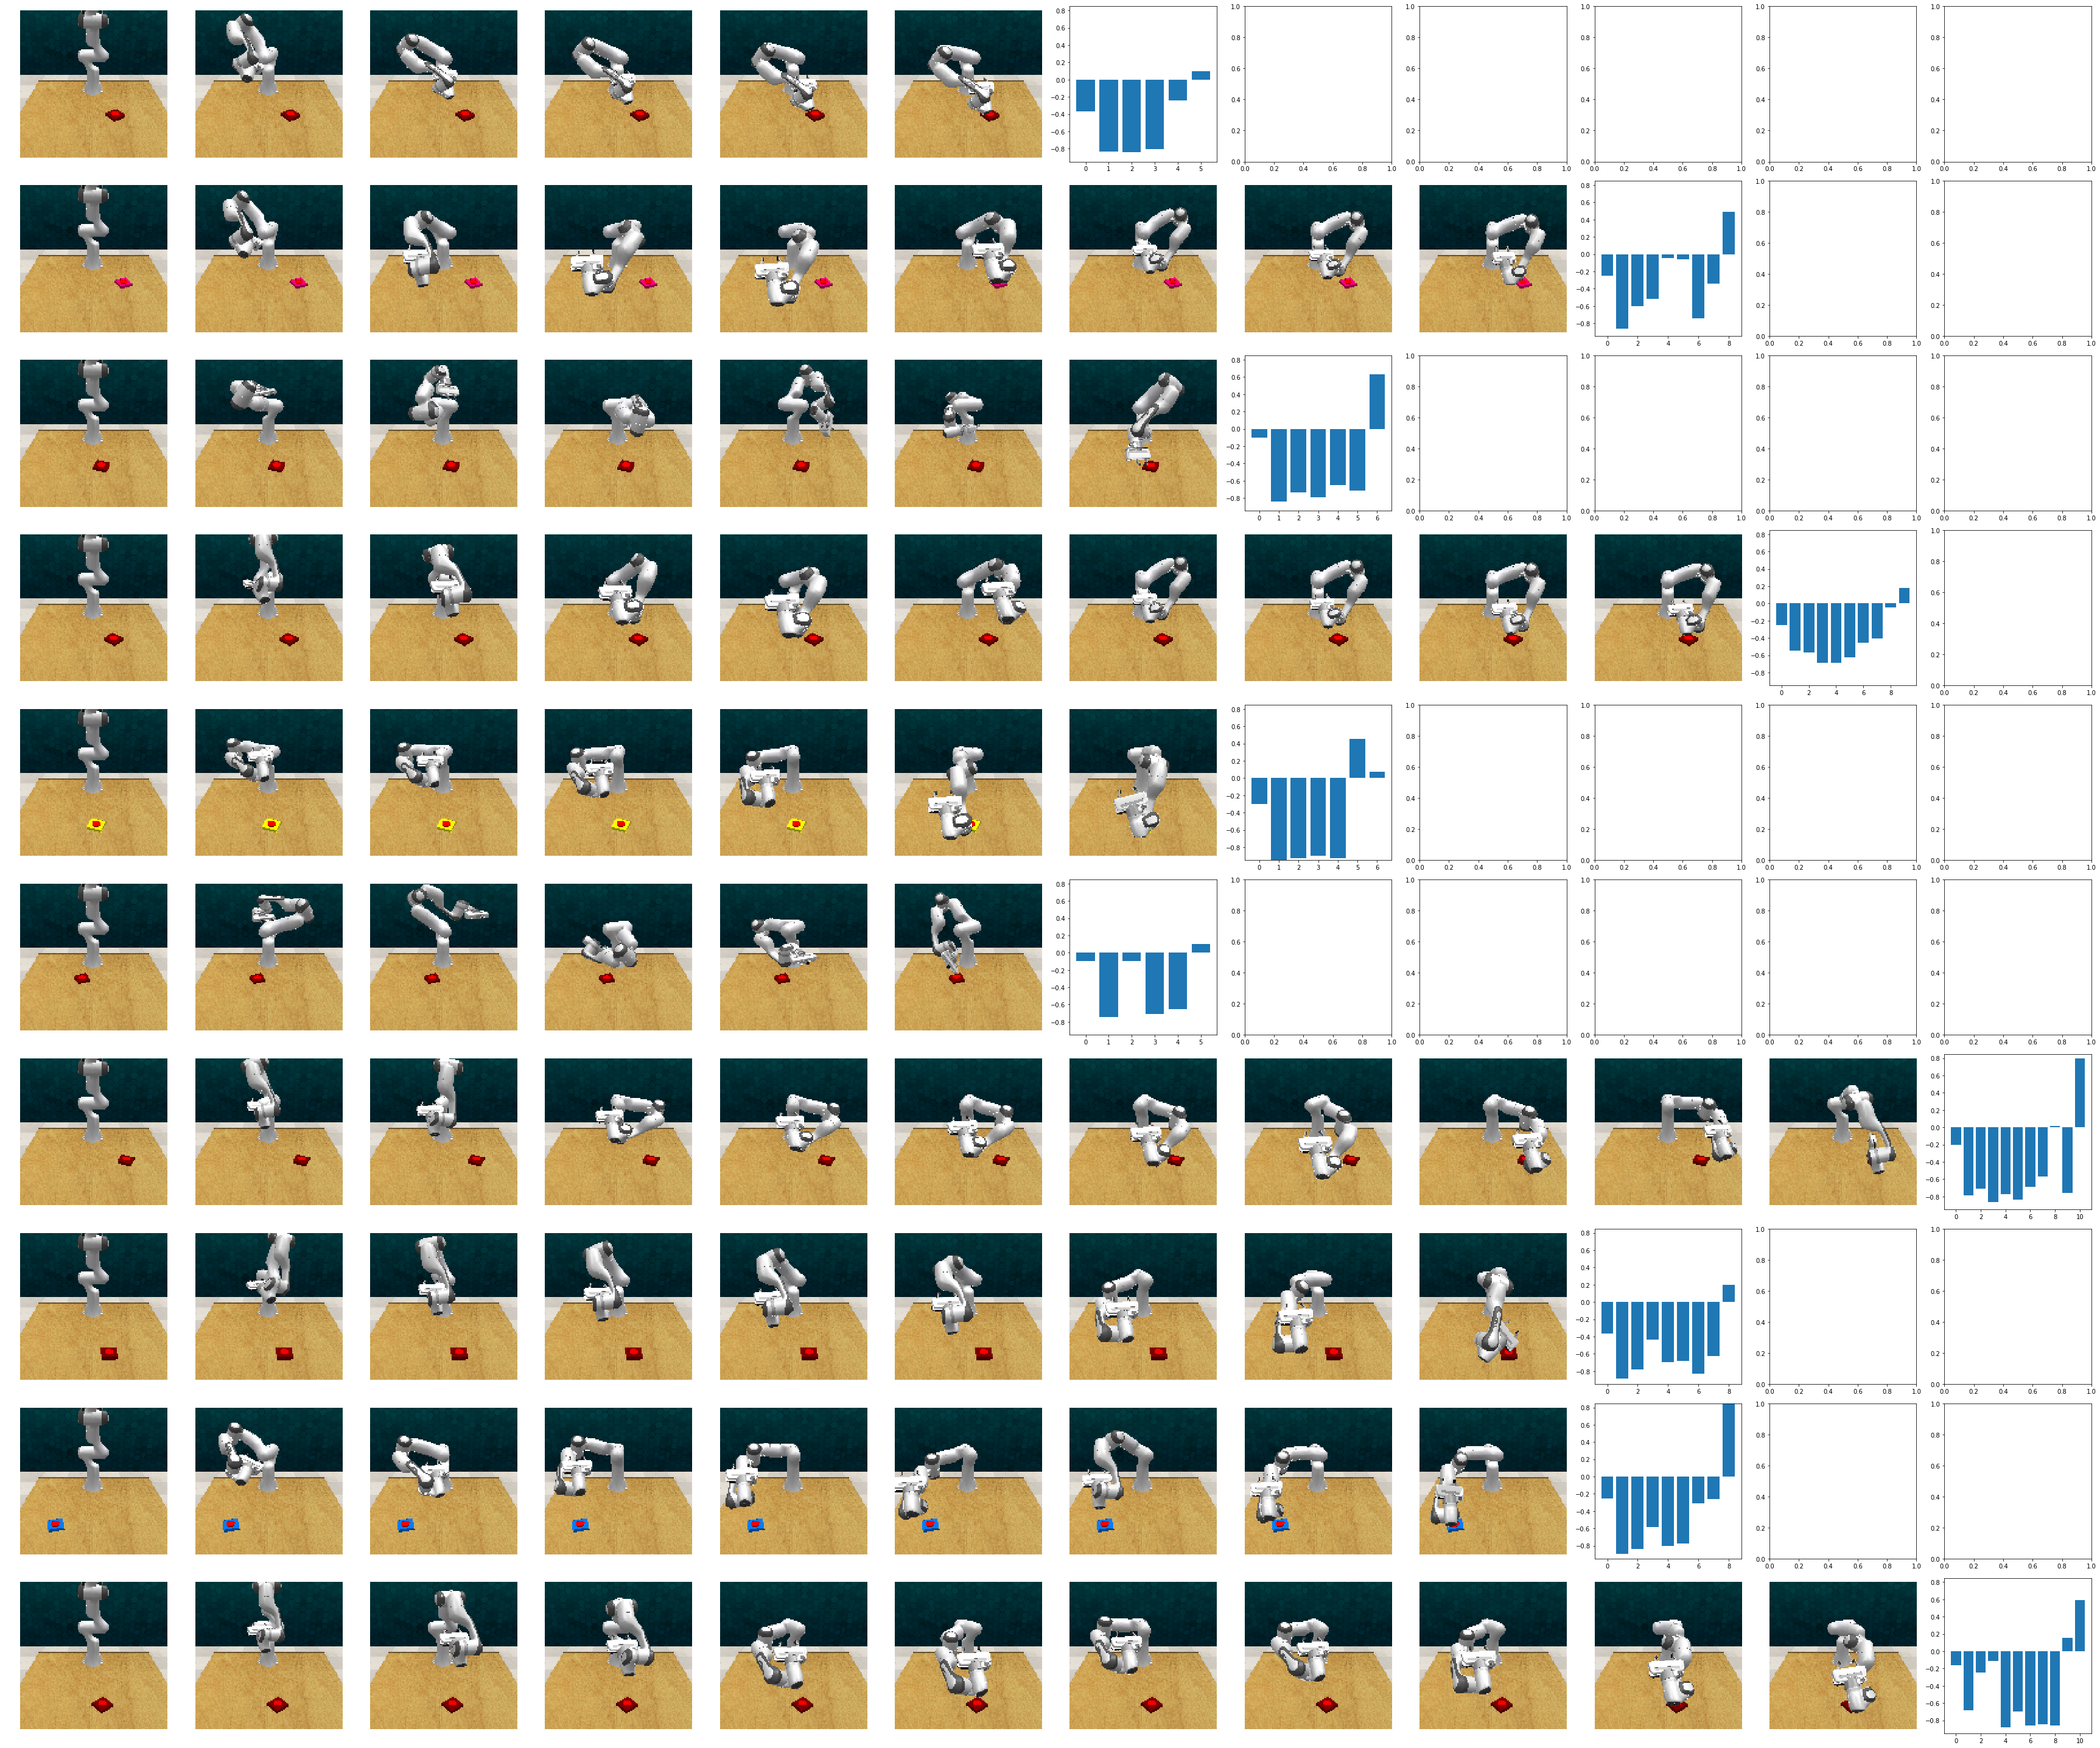

In [69]:
model_name = 'Iteration0-5x20Batch'
step = 450
tuned = RewardMLP(clip_model=clip_model).to(device)
tuned.load_state_dict(torch.load(f'{model_path}/{model_name}/{step}.pt'))
tuned_logits = compute_logits(succ_imgs, tuned, aug_avg=True)
show_logits(tuned_logits, succ_imgs)

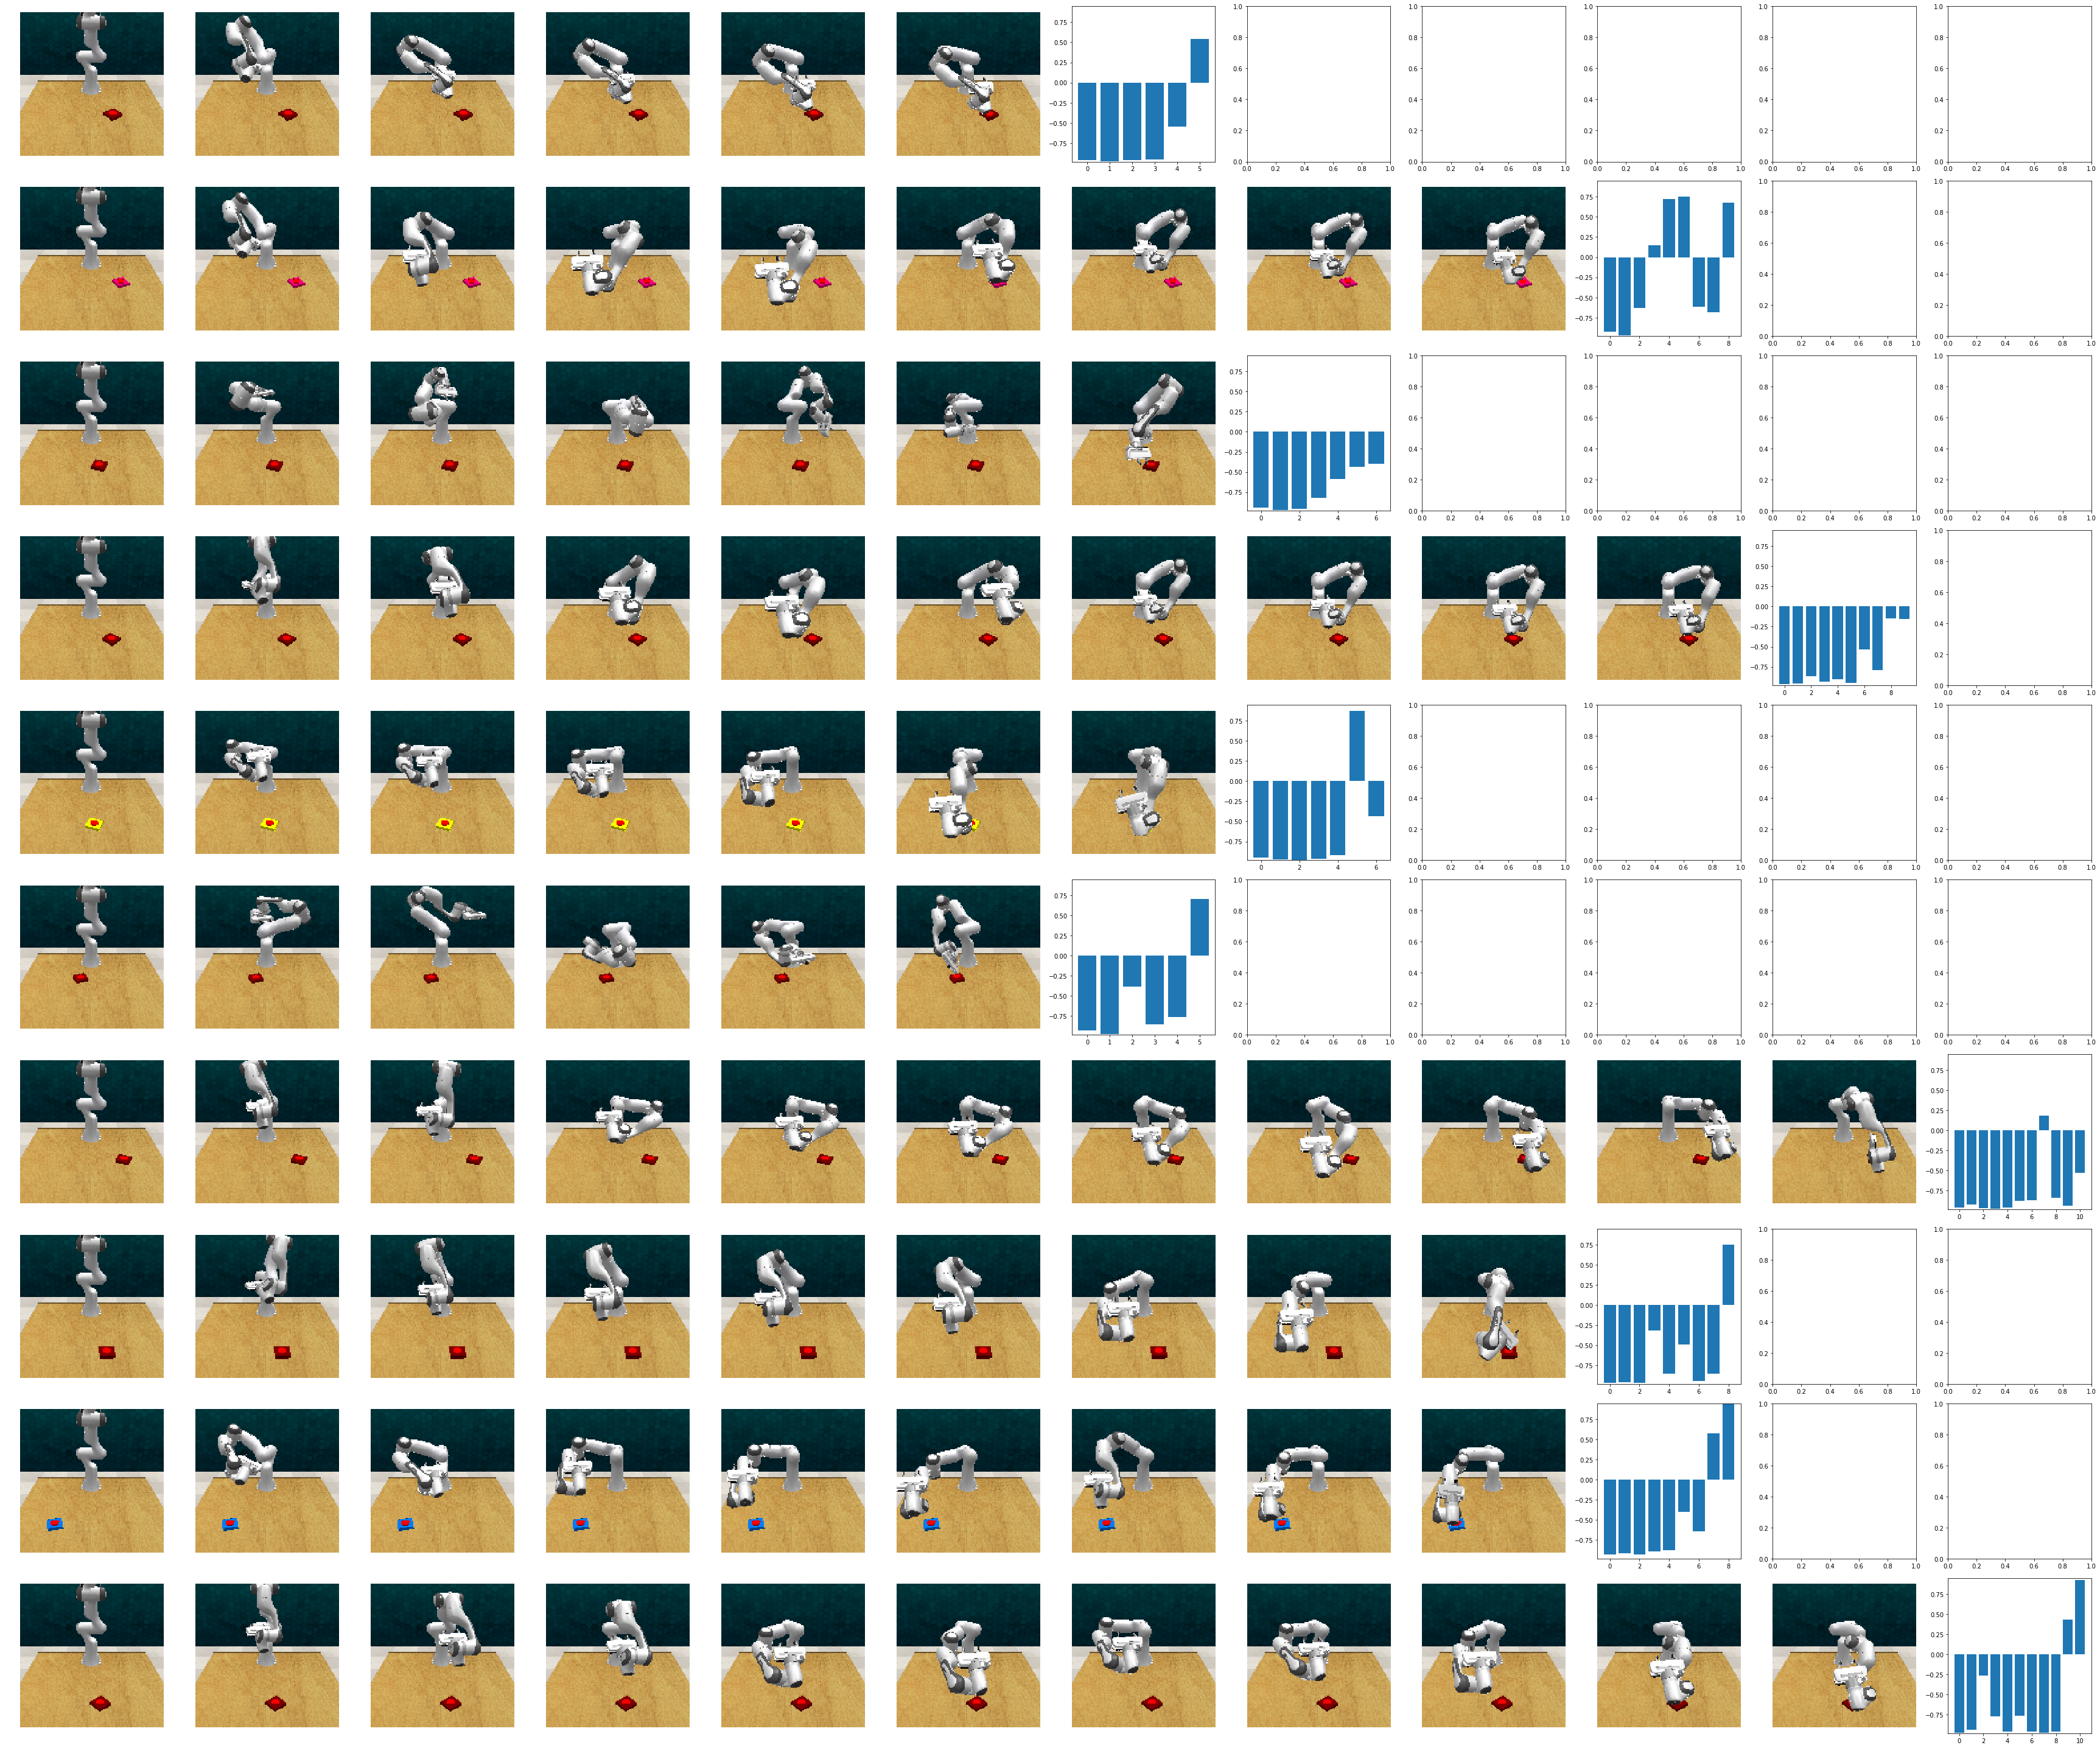

In [72]:
model_name = 'Iteration0-3x40Batch-SmoothSuccess'
step = 400
tuned = RewardMLP(clip_model=clip_model).to(device)
tuned.load_state_dict(torch.load(f'{model_path}/{model_name}/{step}.pt'))
tuned_logits = compute_logits(succ_imgs, tuned, aug_avg=False)
show_logits(tuned_logits, succ_imgs)

/home/mandi/miniconda3/envs/arm/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


DataParallel(
  (module): R3M(
    (cs): CosineSimilarity()
    (bce): BCELoss()
    (sigm): Sigmoid()
    (convnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1

In [75]:
!ls /r3m

ls: cannot access '../r3m': No such file or directory
